In [1]:
from bitarray import bitarray
import random
import numpy as np
import math

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [4]:
import pandas as pd
import os

In [5]:
file = pd.read_csv("heart.csv")
file.head()
file.values

array([[63.,  1.,  3., ...,  0.,  1.,  1.],
       [37.,  1.,  2., ...,  0.,  2.,  1.],
       [41.,  0.,  1., ...,  0.,  2.,  1.],
       ...,
       [68.,  1.,  0., ...,  2.,  3.,  0.],
       [57.,  1.,  0., ...,  1.,  3.,  0.],
       [57.,  0.,  1., ...,  1.,  2.,  0.]])

In [6]:
x_train = np.array(file.values[:,:-1])
y_train = np.array(file.values[:,-1]).reshape(-1,1).astype(int)

In [7]:
print(x_train.shape)
print(y_train.shape)
print(sum(y_train))

(303, 13)
(303, 1)
[165]


In [8]:
x_train = StandardScaler().fit_transform(x_train)

In [9]:
fpr_values = []
size_values = []

# Kraska Hash Model

In [10]:
class Kraska_Hash_BloomFilter:
    
    def __init__(self, size, model): #hash count is 1
        self.size = size
      #  self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)
        self.model=model #classifier model associated as hash function
        
    def add(self, num):
        #for seed in range(1,self.hash_count+1):
            #result = mmh3.hash(str(num), seed) % self.size
        result=math.floor(model.predict(num)[0]*(self.size-1))    
        self.bit_array[result] = 1
            
    def lookup(self, num):
        #for seed in range(1,self.hash_count+1):
            #result = mmh3.hash(str(num), seed) % self.size
        result=math.floor(self.model.predict(num)[0]*(self.size-1))    
        if self.bit_array[result] == 0:
                return False
        return True

    def add_init(self,x_train,y_train):
        pred = self.model.predict(x_train)
        for i in range(len(pred)):
            if(y_train[i]==1):
                result = math.floor(pred[i][0]*(self.size-1))
                self.bit_array[result] = 1

    def predict(self,x):
        initpred = self.model.predict(x)
        indexes = []
        for i in range(len(initpred)):
            indexes += [math.floor(initpred[i][0]*(self.size-1))]
        pred = []
        for i in indexes:
            pred += [self.bit_array[i]]
        return np.array(pred)

#adds ratio r of an array of random integers of size n to bloom filter bf(input : bf,size,ratio; output: data array)
def addrandom(bf,n,r):
    data=np.empty(n,dtype=int)
    for i in range(0,n):
        data[i]=random.randint(0, 100000000)
    for j in range(0,int(n*r)):
        bf.add(data[j])
    return data

#(Input:bloom filter,number array,ratio of positives; Output:(-1) for false negative, otherwise fpr)
def fpr_kraska_hash(bf,nums):
    pred = bf.predict(x_train)
    tn, fp, fn, tp = confusion_matrix(y_train, pred).ravel() 
    return fp/(fp+tn)

#(Input:bloom filter size, total random numbers, ratio of number inserted; Output:efficient number of hash functions)
def eff_k(m,n,r):
    k=int(m/(int(n*r))*math.log(2))
    if(k==0):
        return 1
    return k

#(Input:size of bloom filter, number of hash functions, total numbers, ratio of numbers inserted; Output: fpr)
def find_fpr(m,model,n,r):
    bf=Kraska_Hash_BloomFilter(model,m)
    data=addrandom(bf,n,r)
    return fpr(bf,data,r)

#(Input:size of bloom filter, total numbers, ratio of numbers inserted; Output: prints inputs and fpr)
def outputs(m,n,r):
    find_fpr(m,model,n,r)
    #print("For m=%d, k=%d, n=%d, r=%.3f: fpr=%.3f"%(m,k,n,r,find_fpr(m,k,n,r)))

In [11]:
def get_data_points_Kraska(x_train,y_train,init_size,diff,num,epochs,fpr_values,size_values):
    batch_size = len(x_train)
    input_dim = x_train.shape[1]
    additional_metrics = ['acc']
    loss_function = BinaryCrossentropy()
    optimizer = Adam()
    verbosity_mode = 0
    for i in range(0,num):
        layer_size = init_size + (diff*i)
        number_of_epochs = epochs
        model = Sequential()
        model.add(Dense(layer_size,input_dim=input_dim,activation='relu'))
        model.add(Dense(1,activation='sigmoid'))
        model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)
        history = model.fit(x_train, y_train, batch_size = batch_size, epochs=number_of_epochs, verbose=verbosity_mode)

        print("Number of nodes: %d" %(init_size + (diff*i)))
        plt.plot(history.history['acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.show()
        plt.plot(history.history['loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.show()

        model.save('model_test.h5')
        model_size = os.stat('model_test.h5').st_size

        m = (8*model_size)//100
        net_size = 1.01*model_size/1024

        bf=Kraska_Hash_BloomFilter(m,model)
        bf.add_init(x_train,y_train)
        fpr = fpr_kraska_hash(bf,x_train)

        print("Size: %f KB - FPR: %f \n\n\n" % (net_size,fpr))
        fpr_values += [fpr]
        size_values += [net_size]

Number of nodes: 1


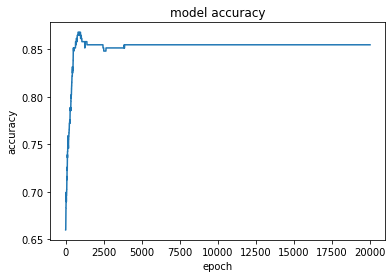

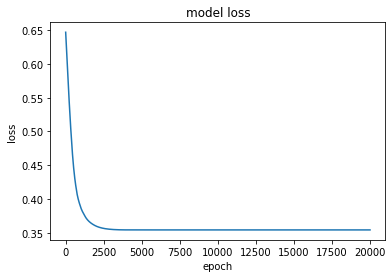

Size: 25.186875 - FPR: 0.608696 



Number of nodes: 2


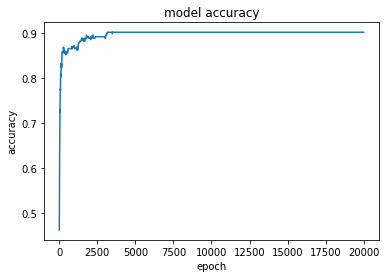

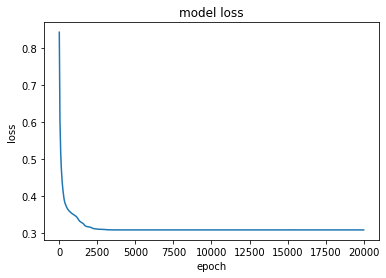

Size: 33.566719 - FPR: 0.579710 



Number of nodes: 3


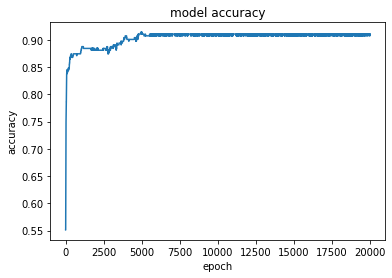

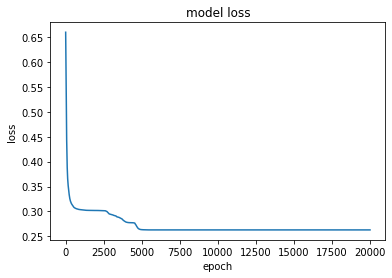

Size: 41.946562 - FPR: 0.043478 



Number of nodes: 4


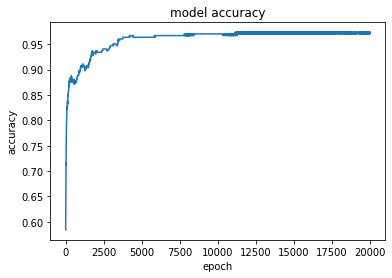

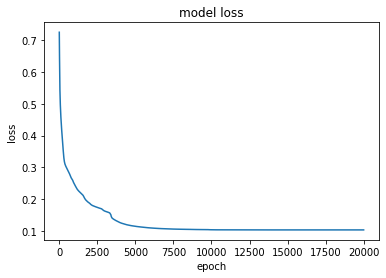

Size: 50.744609 - FPR: 0.108696 



Number of nodes: 5


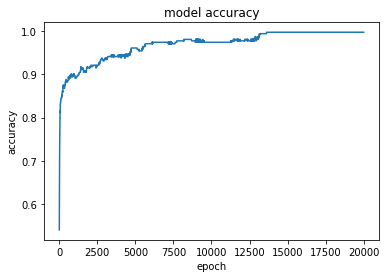

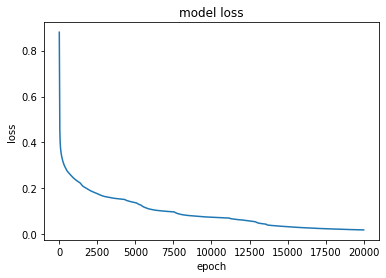

Size: 61.144453 - FPR: 0.094203 



Number of nodes: 6


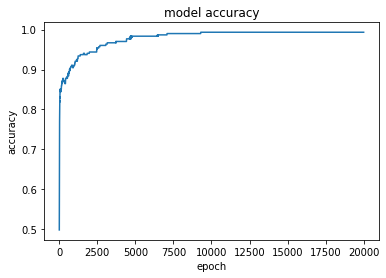

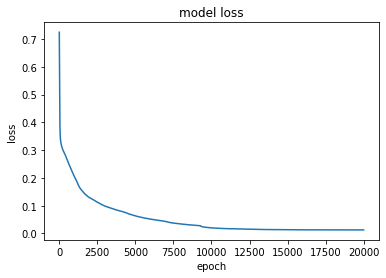

Size: 69.524297 - FPR: 0.014493 



Number of nodes: 7


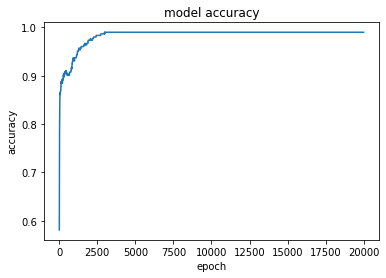

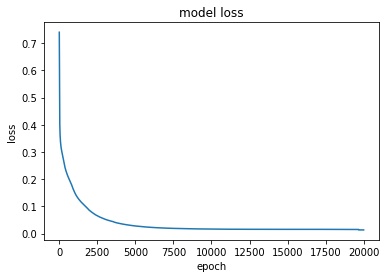

Size: 81.944141 - FPR: 0.021739 



Number of nodes: 8


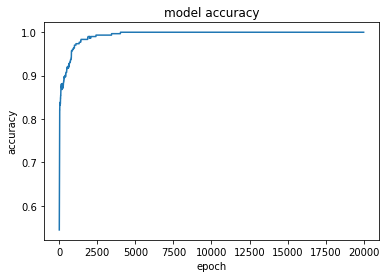

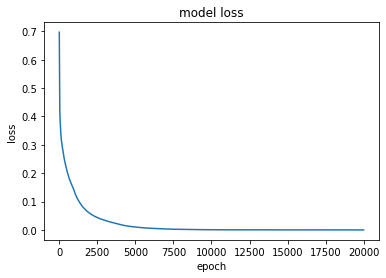

Size: 92.856875 - FPR: 0.000000 



Number of nodes: 9


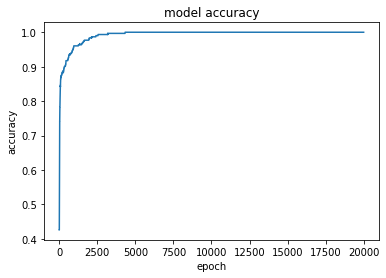

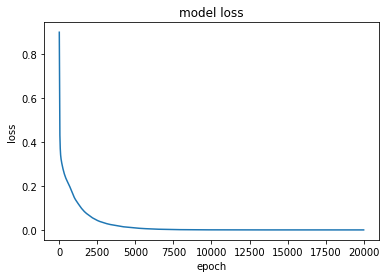

Size: 101.236719 - FPR: 0.000000 



Number of nodes: 10


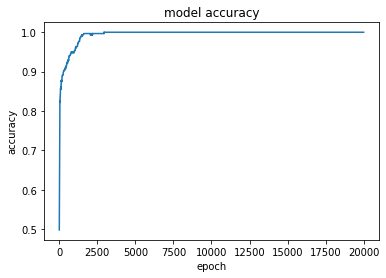

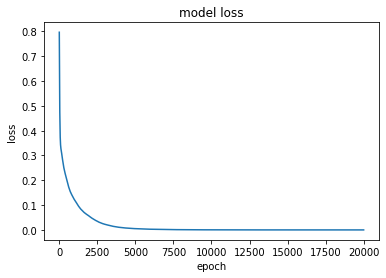

Size: 111.960078 - FPR: 0.000000 



Number of nodes: 11


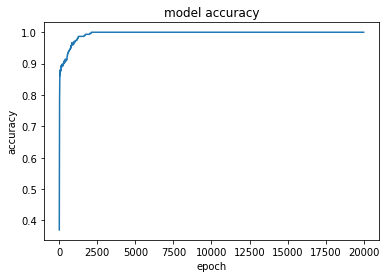

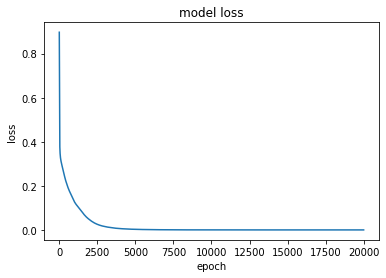

Size: 122.359922 - FPR: 0.000000 



Number of nodes: 12


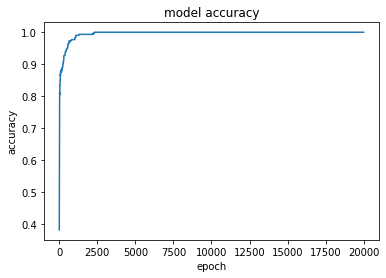

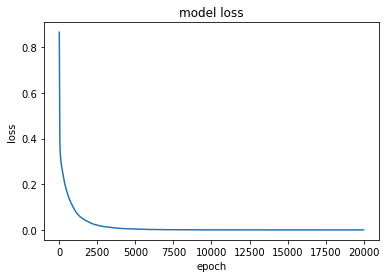

Size: 131.063281 - FPR: 0.000000 



Number of nodes: 13


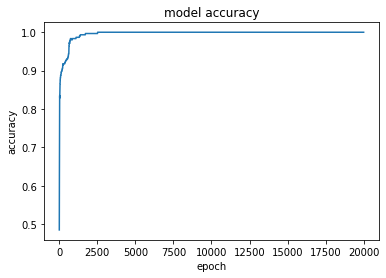

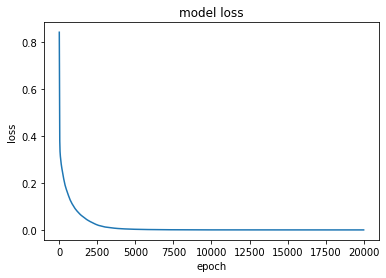

Size: 141.463125 - FPR: 0.000000 



Number of nodes: 14


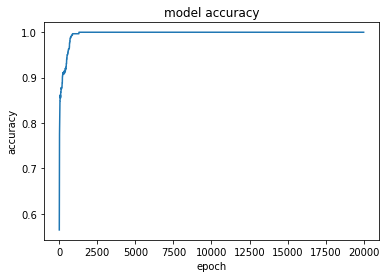

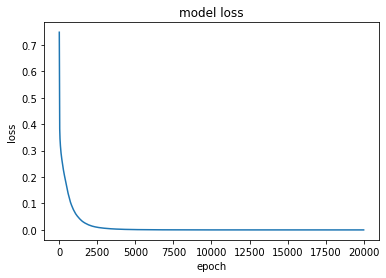

Size: 152.557344 - FPR: 0.000000 



Number of nodes: 15


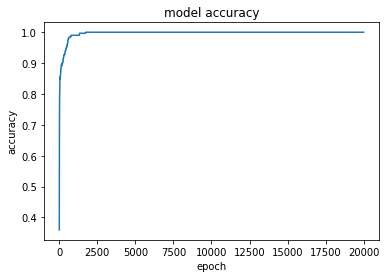

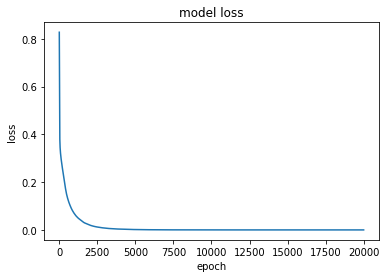

Size: 162.957188 - FPR: 0.000000 



Number of nodes: 16


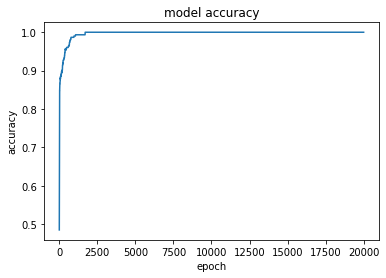

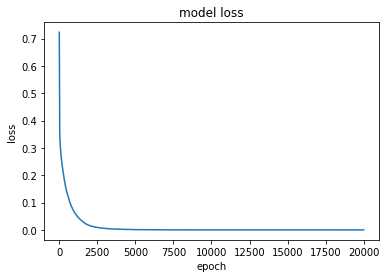

Size: 173.680547 - FPR: 0.000000 



Number of nodes: 17


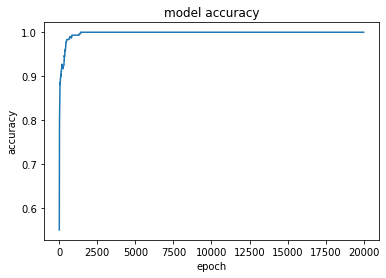

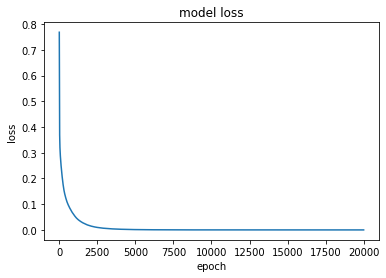

Size: 184.080391 - FPR: 0.000000 



Number of nodes: 18


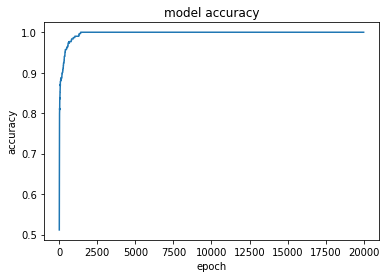

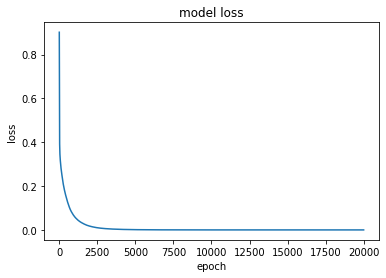

Size: 194.803750 - FPR: 0.000000 



Number of nodes: 19


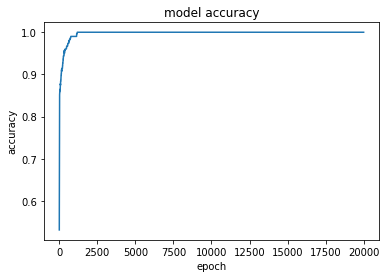

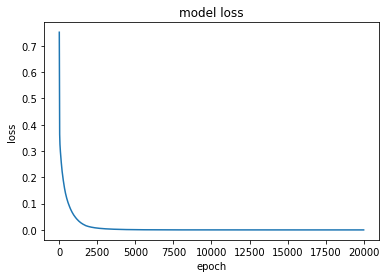

Size: 205.203594 - FPR: 0.000000 



Number of nodes: 20


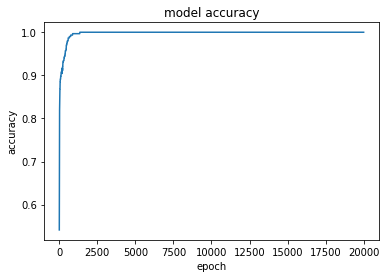

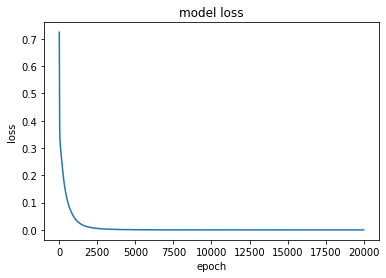

Size: 221.986953 - FPR: 0.000000 





In [12]:
get_data_points_Kraska(x_train,y_train,1,1,20,20000,fpr_values,size_values)

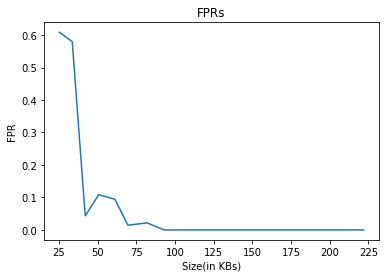

In [13]:
plt.plot(size_values,fpr_values)
plt.title('FPRs')
plt.xlabel('Size(in KBs)')
plt.ylabel('FPR')
plt.show()

# Projection model

In [14]:
class Projection_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,1,size=(hash_count,dim)) #random vectors(each row) from normal distribution, not unit vectors
        self.unit_vectors = np.transpose(vectors/np.sqrt(np.transpose([np.sum(np.multiply(vectors,vectors),1)]))) #Matrix where each column is a unit vector, used as hash
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)

    def give_hash_values(self,X):
        projections = np.dot(X,self.unit_vectors) #Projections of datapoints on unit vectors
        norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
        hash_values = (norm_proj*self.size).astype(int) #All values are integers in the range [0,size-1]
        return hash_values #Each row contains hash values of that datapoint

    def add(self,x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            self.bit_array[i] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in hash_values:
            for j in i:
                self.bit_array[j] = 1
            
    def lookup(self, x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            if(self.bit_array[i]==0):
                return False
        return True

    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in pos_hash_values:
        for j in i:
            if(bf.bit_array[j]==0):
                return -1
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

In [36]:
def get_data_points_Projection(x_train,y_train,init_size,diff,num,epochs,fpr_values,size_values):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = eff_k(m,n,1)
        fpr = 1
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>temp):
                fpr = temp
        print("Size: %d Bits - FPR: %f \n\n\n" % (m,fpr))
        fpr_values += [fpr]
        size_values += [m]

In [80]:
fpr_values = []
size_values = []

In [81]:
get_data_points_Projection(x_train,y_train,5,10,200,100,fpr_values,size_values)

Size: 5 Bits - FPR: 1.000000 



Size: 15 Bits - FPR: 0.768116 



Size: 25 Bits - FPR: 0.717391 



Size: 35 Bits - FPR: 0.768116 



Size: 45 Bits - FPR: 0.565217 



Size: 55 Bits - FPR: 0.586957 



Size: 65 Bits - FPR: 0.586957 



Size: 75 Bits - FPR: 0.507246 



Size: 85 Bits - FPR: 0.528986 



Size: 95 Bits - FPR: 0.594203 



Size: 105 Bits - FPR: 0.521739 



Size: 115 Bits - FPR: 0.536232 



Size: 125 Bits - FPR: 0.500000 



Size: 135 Bits - FPR: 0.420290 



Size: 145 Bits - FPR: 0.384058 



Size: 155 Bits - FPR: 0.391304 



Size: 165 Bits - FPR: 0.347826 



Size: 175 Bits - FPR: 0.318841 



Size: 185 Bits - FPR: 0.420290 



Size: 195 Bits - FPR: 0.333333 



Size: 205 Bits - FPR: 0.318841 



Size: 215 Bits - FPR: 0.340580 



Size: 225 Bits - FPR: 0.333333 



Size: 235 Bits - FPR: 0.268116 



Size: 245 Bits - FPR: 0.297101 



Size: 255 Bits - FPR: 0.318841 



Size: 265 Bits - FPR: 0.326087 



Size: 275 Bits - FPR: 0.224638 



Size: 285 Bits - FPR: 0.260870 

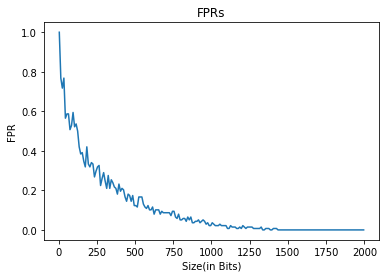

In [82]:
plt.plot(size_values,fpr_values)
plt.title('FPRs')
plt.xlabel('Size(in Bits)')
plt.ylabel('FPR')
plt.show()

# Normal Bloom Filter Values

In [83]:
def ideal_fpr(m,n):
    k = eff_k(m,n,1)
    return (1-(1-(1/m))**(n*k))**k

In [84]:
print(sum(y_train))
print(len(y_train))

[165]
303


In [85]:
n = sum(y_train)
y_ideal = [ideal_fpr(x,n) for x in size_values]

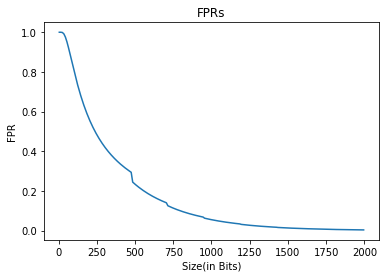

In [86]:
plt.plot(size_values,y_ideal)
plt.title('FPRs')
plt.xlabel('Size(in Bits)')
plt.ylabel('FPR')
plt.show()

# FPR Comparison between Projection Model and Normal Bloom Filter

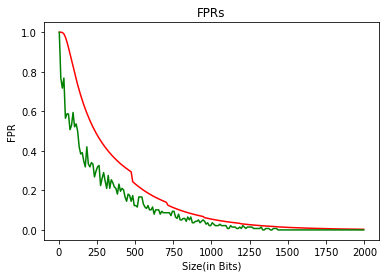

In [87]:
plt.plot(size_values,y_ideal,color='red')
plt.plot(size_values,fpr_values,color='green')
plt.title('FPRs')
plt.xlabel('Size(in Bits)')
plt.ylabel('FPR')
plt.show()
# Red- Normal Bloom Filter
# Green- Projection Model